### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
import time, os, sys
import textencoder

In [2]:
from fastai import *
from fastai.text import *

In [3]:
enc = textencoder.get_encoder()

In [4]:
enc.encoder['xxpad']

50257

### Init

In [ ]:
def node_info():
    print(f'Python executable: {sys.executable}\nname:\t\t{__name__}')
    if torch.cuda.is_available():
        print('Cuda available:\tTrue')
        print(f'Nr of Devices:\t{torch.cuda.device_count()}')
        print(f'Current Device:\t{torch.cuda.current_device()}')
        for i in range(torch.cuda.device_count()):
            print(f'Device ({i}):\t{torch.cuda.get_device_name(i)}\nCapability:\t{torch.cuda.get_device_capability(i)}')
    else:
        print('No GPU Available.')
node_info()

In [6]:
BOS,FLD,UNK,PAD = 'xxbos','\n','xxunk','xxpad'
MSK, SEP, EOS, SPKA, SPKB = 'xxmsk', 'xxsep', 'xxeos', 'A:', 'B:'
TK_MAJ,TK_UP,TK_REP,TK_WREP = 'xxmaj','xxup','xxrep','xxwrep'
defaults.text_spec_tok = [UNK,PAD,MSK,SEP,BOS,FLD,TK_MAJ,TK_UP,
                          TK_REP,TK_WREP,EOS,SPKA,SPKB]

### Helpers

In [7]:
def to_gb(x):
    return np.round(x / 1e9, 2)

def get_mem():
    s = ''
    s += f'Allocated:\t{to_gb(torch.cuda.memory_allocated())} GB'
    s += f'\nMax Allocated:\t{to_gb(torch.cuda.max_memory_allocated())} GB'
    s += f'\nCached:\t\t{to_gb(torch.cuda.memory_cached())} GB'
    s += f'\nMax Cached:\t{to_gb(torch.cuda.max_memory_cached())} GB'
    print(s)
get_mem()

Allocated:	0.0 GB
Max Allocated:	0.0 GB
Cached:		0.0 GB
Max Cached:	0.0 GB


In [8]:
def clones(module, N):
    """Produces N identical layers."""
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

In [9]:
def acc(prediction, target, thresh=0.5, sigmoid=True)->Rank0Tensor:
    "Compute accuracy when `prediction` and `target` are the same size."
    if sigmoid: prediction = prediction.sigmoid()
    return ((prediction>thresh)==target.byte()).float().mean()

## Model

In [10]:
class GeLU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(0.79788 * (x + 0.044715 * torch.pow(x, 3))))

In [11]:
DimDropout = RNNDropout

In [12]:
class Encoder(nn.Module):
    r"""
    Contains N identical copies of a 'EncoderLayer'.
    
    During the forward pass, the input is passed sequentially
    from one EncoderLayer to the next.
    
    Input:
    - src: A Tensor of shape (batch-size, sequence-length-src, d_model)
    
    Output: A Tensor of the same shape as 'src'
    """
    def __init__(self, N, d_model, d_ff, h, p_att, p_ff, p_res, use_concat):
        super().__init__()
        layer = EncoderLayer(d_model, d_ff, h, p_att, p_ff, p_res, use_concat)
        self.layers = clones(layer, N)
        
    def forward(self, src, mask):
        for l in self.layers:
            src = l(src, mask)
        return src

In [13]:
class EncoderLayer(nn.Module):
    r"""
    Contains Two Sublayers:
    - A 'Multiattn' layer
    - A 'Feedforward' layer
    
    The input is passed through these two layers sequentially, in that order.
    
    Input:
    - src: A Tensor of shape (batch-size, sequence-length-src, d_model)
    
    Output: A Tensor of the same shape as 'src'
    """
    def __init__(self, d_model, d_ff, h, p_att, p_ff, p_res, use_concat):
        super().__init__()
        self.L0 = Multiattn(d_model, h, p_att, p_res, use_concat)
        self.L1 = Feedforward(d_model, d_ff, p_ff, p_res, use_concat)
    
    def forward(self, src, mask):
        src = self.L0(src, mask)
        return self.L1(src)

In [14]:
class Feedforward(nn.Module):
    r"""
    Contains a residual connection wrapping around
    a two layer feed-forward network with dropout,
    followed by layer normalization.
    
    Input:
    - x: A Tensor of shape (batch-size, sequence-length, d_model)
    
    Output: A Tensor of the same shape as 'x'
    """
    def __init__(self, d_model, d_ff, p_ff, p_res, use_concat):
        super().__init__()
        self.use_cat = use_concat
        _layers = []
        _layers.append(nn.LayerNorm(d_model))
        _layers.append(GeLU())
        _layers.append(nn.Linear(d_model, d_ff))
        _layers.append(nn.LayerNorm(d_ff))
        _layers.append(GeLU())
        _layers.append(nn.Dropout(p_ff))
        _layers.append(nn.Linear(d_ff, d_model))
        _layers.append(nn.Dropout(p_res))
        self.layers = nn.Sequential(*_layers)
        if use_concat: self.MC = nn.Linear(d_model*2, d_model)
        
    def forward(self, x):
        if self.use_cat:
            return self.MC(torch.cat([x, self.layers(x)], dim=-1))
        else:
            return x + self.layers(x)

In [44]:
class Multiattn(nn.Module):
    r"""
    Contains a residual connection wrapping around
    a self-attention function with dropout,
    followed by layer normalization.
    
    Input:
    The sequence-length of the query can be different from the key and value.
    - Q: A Tensor of shape (batch-size, sequence-length, d_model)
    - K: A Tensor of shape (batch-size, sequence-length, d_model)
    - V: A Tensor of shape (batch-size, sequence-length, d_model)
    
    Output: A Tensor of the same shape as 'Q' (query)
    """
    def __init__(self, d_model, h, p_att, p_res, use_concat):
        super().__init__()
        self.d_model, self.h, self.d_k = d_model, h, d_model // h
        self.sqrt_d_k = math.sqrt(self.d_k)
        self.use_cat = use_concat
        
        self.norm = nn.LayerNorm(d_model)
        self.actv = GeLU()
        
        self.MQ = nn.Linear(d_model, d_model)
        self.MK = nn.Linear(d_model, d_model)
        self.MV = nn.Linear(d_model, d_model)
        
        self.Softmax = nn.Softmax(dim=-1)
        self.att_drop = nn.Dropout(p_att)
        self.MO = nn.Linear(d_model, d_model)
        self.res_drop = nn.Dropout(p_res)
        if use_concat: self.MC = nn.Linear(d_model*2, d_model)
        
    def forward(self, x, mask=None):
        bs, h, d_k = x.size(0), self.h, self.d_k
        
        x = self.actv(self.norm(x))
        
        Q = self.MQ(x).view(bs, -1, h, d_k).transpose(1, 2)
        K = self.MK(x).view(bs, -1, h, d_k).transpose(1, 2)
        V = self.MV(x).view(bs, -1, h, d_k).transpose(1, 2)
        
        Q = (Q @ K.transpose(-1, -2) / self.sqrt_d_k)
        if mask is not None:
            Q = Q.masked_fill(mask[:,:,:Q.size(-2),:Q.size(-1)], -float('inf')) # might have to cast to float for this
        Q = self.att_drop(self.Softmax(Q)) @ V
        Q = self.res_drop(self.MO(Q.transpose(1, 2).contiguous().view(bs, -1, self.d_model)))
        if self.use_cat:
            Q = self.MC(torch.cat([x, Q], dim=-1))
        else:
            Q = x + Q
        return Q

In [16]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d_model):
        super().__init__()
        freq = torch.exp(torch.arange(1.0, d_model+1, 2) * -(math.log(300.0) / d_model))
        self.register_buffer('freq', freq)
    
    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [17]:
class EmbeddingLayer(nn.Module):
    r"""
    Contains the Embedding Layer and adds positional encodings.
    
    Converts a Tuple of Lists of numericalized tokens into embedding Vectors.
    Then adds precomputed cos and sin values to the different dimensions (positional encoding)
    The input Lists can be of different length and the batch size can be changed at any point,
    even during training, without having to change the model.
    However the sequence length of 'tgt' might have to have a constant length,
    depending on if the final layer (not contained in this module) can cope with varying lengths.
    
    Input:
    - src: A list of ints of shape (batch-size, sequence-length-src)
    
    Output:A Tensor of shape (batch-size, sequence-length-src, embedding-dim(aka. d_model))
    """
    def __init__(self, vocab_size, ctx_len, learned_pos_enc, d_model, p_drop):
        super().__init__()
        self.l_pos = learned_pos_enc
        self.embed = nn.Embedding(vocab_size, d_model)
        self.emb_drop = nn.Dropout(p_drop)
        # self.init_pos_enc(ctx_len, d_model)
        self.pe = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.pe_drop = nn.Dropout(p_drop)
        
    def forward(self, src):
        src = self.emb_drop(self.embed(src))
        # src = src + self.pe[:, :src.size(1)]
        pos = torch.arange(0, src.size(1), device=src.device, dtype=(torch.int64 if self.l_pos else src.dtype))
        src = self.pe_drop(src + self.pe(pos)[None])
        return src
    
    def init_pos_enc(self, ctx_len, d_model):
        _max_len = max_seq_len*2 if 'max_seq_len' in globals() else 640
        div = torch.exp(torch.arange(1.0, d_model+1, 2) * -(math.log(300.0) / d_model))
        pos = torch.arange(1.0, ctx_len + 1)
        foo = torch.ger(pos, div)
        pe = torch.cat([foo.sin(), foo.cos()], dim=-1).unsqueeze(0)
        self.register_buffer('pe', pe)

In [18]:
class FinalLayer(nn.Module):
    r"""
    This Module takes the rich reqresentation of the 'Decoder'
    and converts it into a single scalar number. A probability
    between 0 and 1.
    
    Input:
    - x: A Tensor of shape (batch-size, sequence-length, d_model)
    
    Output: A single scalar number between zero and one
    """
    def __init__(self, n_out, d_model, p_drop, tie_enc=None):
        super().__init__()
        _layers = []
        _layers.append(nn.LayerNorm(d_model))
        _layers.append(GeLU())
        lin = nn.Linear(d_model, n_out)
        if tie_enc is not None: lin.weight = tie_enc.weight
        _layers.append(lin)
        self.layers = nn.Sequential(*_layers)
        
    def forward(self, x):
        return self.layers(x)

In [22]:
class FinalLayerClassifier(nn.Module):
    r"""
    This Module takes the rich reqresentation of the 'Decoder'
    and converts it into a single scalar number. A probability
    between 0 and 1.
    
    Input:
    - x: A Tensor of shape (batch-size, sequence-length, d_model)
    
    Output: A single scalar number between zero and one
    """
    def __init__(self, n_out, d_model, p_drop):
        super().__init__()
        _layers = []
        _layers.append(nn.LayerNorm(d_model * 100))
        _layers.append(GeLU())
        _layers.append(nn.Linear(d_model * 100, 50))
        _layers.append(nn.LayerNorm(50))
        _layers.append(GeLU())
        _layers.append(nn.Dropout(p_drop))
        _layers.append(nn.Linear(50, n_out)) # 2 or 1 out features
        self.layers = nn.Sequential(*_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

In [23]:
class FinalLayerClassifier(nn.Module):
    r"""
    This Module takes the rich reqresentation of the 'Decoder'
    and converts it into a single scalar number. A probability
    between 0 and 1.
    
    Input:
    - x: A Tensor of shape (batch-size, sequence-length, d_model)
    
    Output: A single scalar number between zero and one
    """
    def __init__(self, n_out, d_model, p_drop):
        super().__init__()
        _layers = []
        _layers.append(nn.LayerNorm(d_model * 2))
        _layers.append(GeLU())
        _layers.append(nn.Linear(d_model * 2, 50))
        _layers.append(nn.LayerNorm(50))
        _layers.append(GeLU())
        _layers.append(nn.Dropout(p_drop))
        _layers.append(nn.Linear(50, n_out)) # 2 or 1 out features
        self.layers = nn.Sequential(*_layers)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=False)
        mx  = torch.max(x, dim=1, keepdim=False)[0]
        x = torch.cat([avg, mx], dim=1)
        x = self.layers(x)
        return x

In [24]:
class Transformer(nn.Module):
    r"""
    Wrapper around the three pieces that make up the model.
    Passes the input from one part to the next.
    
    Input:
    - src: A list of ints of shape (batch-size, sequence-length-src)
    - tgt: A list of ints of shape (batch-size, sequence-length-tgt)
    The first list is the 'source' text and the second list is the 'target' text.
    
    Output:
    - prediction: a Tensor of whatever shape the final layer returns. The first
    dimension is always batch-size.
    """
    def __init__(self, emb, enc_dec, final, use_msk):
        super().__init__()
        self.use_msk = use_msk
        self.emb = emb
        self.enc_dec = enc_dec
        self.final = final
        
    def forward(self, src):
        bs, l = src.size()
        src = self.emb(src)
        mask = torch.triu(src.new_ones(l, l), diagonal=1).byte()[None,None] if self.use_msk else None
        src = self.enc_dec(src, mask=mask)
        src = self.final(src)
        return src

In [25]:
def predict(learn, enc, text, n_words, temperature=1, min_p=None):
    assert not learn.model.training, 'model is in training mode'
    xb, yb = LongTensor([enc.encode(text)]).to(learn.data.device), LongTensor([0]).to(learn.data.device)
    new_idx = xb.tolist()[0]
    for _ in range(n_words):
        res = learner.pred_batch(batch=(xb, yb))[0][-1]
        if min_p is not None: 
            if (res >= min_p).float().sum() == 0:
                warn(f"There is no item with probability >= {min_p}, try a lower value.")
            else: res[res < min_p] = 0.
        if temperature != 1.: res.pow_(1 / temperature)
        idx = torch.multinomial(res, 1).item()
        new_idx.append(idx)
        xb = xb.new_tensor([new_idx])
    return enc.decode(new_idx)

### Model Factory

In [26]:
def init_transformer(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None: nn.init.normal_(m.weight, 0., 0.02)
        if hasattr(m, 'bias') and m.bias is not None:     nn.init.constant_(m.bias, 0.)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None: nn.init.normal_(m.weight, 1., 0.02)
        if hasattr(m, 'bias') and m.bias is not None:     nn.init.constant_(m.bias, 0.)

In [27]:
def make_model(vocab_size, n_classes=1, N=6, d_model=512, d_ff=1024, h=8, p_drop=0.1, tie_weights=False, use_concat=False, use_msk=False, learned_pos=False):
    r"""
    Takes in a bunch of Hyperparameters and uses them to contruct different parts of the network.
    Initializes all parameters of the network, using the xavier_uniform initialization.
    
    Args:
    - vocab_size: size of the vocab
    - n_classes: number of classes to predict
    - N: Number of Encoder / Decoder Layers
    - d_model: embedding size
    - d_ff: Dimensionality of the Feed-Forward layers
    - h: nr of attention heads
    - p_drop: Dropout probability
    - tie_weights: last layer shares same weights as embedding
    - use_concat: concat network vs residual network
    - use_msk: mask words during attention
    - learned_pos: sin/cos vs learned positional enc
    
    Returns:
    A 'WholeModel' pytorch Module.
    Takes in two argument to pass to the embedding_layer
    and returns whatever the final_layer outputs.
    """
    assert d_model % h == 0                          , 'd_model has to be a multiple of h'
    assert n_classes == vocab_size or not tie_weights, 'weight tying can only be used when n_classes == vocab_size'
    
    p_emb, p_att, p_ff, p_res, p_out = [p_drop] * 5 if isinstance(p_drop, float) else p_drop
    
    emb_layer    = EmbeddingLayer(vocab_size, 512, learned_pos, d_model, p_emb)
    enc_dec      = Encoder(N, d_model, d_ff, h, p_att, p_ff, p_res, use_concat)
    tie_enc      = emb_layer.embed if tie_weights else None
    final_layer  = FinalLayer(n_classes, d_model, p_out, tie_enc)

    model = Transformer(emb_layer, enc_dec, final_layer, use_msk)
    
    model.apply(init_transformer)
    return model

### Learner(+Model) Factory

In [28]:
def create_lm(data, N=5, d_model=512, d_ff=1024, h=8, p_drop=0.1, tie_weights=True, use_concat=True, use_msk=True, learned_pos=False, fp_16=True):
    r"""
    Bundle the model creation and learner creation in one function
    """
    vocab_size = len(data.vocab.itos)
    
    model = make_model(vocab_size, vocab_size, N, d_model, d_ff, h, p_drop, tie_weights, use_concat, use_msk, learned_pos)
    groups = None
    learn = Learner(data, model, metrics=accuracy, layer_groups=groups)
    if fp_16: learn = learn.to_fp16(dynamic=True)
    return learn

In [29]:
def load_state(path):
    state = torch.load(path, map_location=torch.device('cpu'))
    if 'model' in state: state = state['model']
    for e in state: state[e] = state[e].float()
    return state

In [30]:
def create_pretrained_lm(data, pretrained_path, N=5, d_model=512, d_ff=1024, h=8, p_drop=0.1, tie_weights=False, use_concat=True, use_msk=True, learned_pos=False, fp_16=True):
    vocab_size = len(data.vocab.itos)
    
    model = make_model(vocab_size, vocab_size, N, d_model, d_ff, h, p_drop, tie_weights, use_concat, use_msk, learned_pos)
    state = load_state(pretrained_path)
    model.load_state_dict(state, strict=True)
    model = model.float()
    layers = flatten_model(model)
    groups = [nn.Sequential(*layers[1:-1])] + [nn.Sequential(*[layers[0], layers[-1]])]
    learn = Learner(data, model, metrics=accuracy, layer_groups=groups)
    if fp_16: learn = learn.to_fp16(dynamic=True)
    return learn

In [31]:
def replace_last_layer(model, new_layer, tie_weights=False):
    new_layer.apply(init_transformer)
    model.final = None
    model.final = deepcopy(new_layer).to(next(model.parameters()).data)
    if tie_weights:
        assert model.final.lin.weight.shape == model.emb.embed.weight.shape, 'weight shapes have to match'
        model.final.lin.weight = model.emb.embed.weight
    return model

def create_pretrained_cl(data, pretrained_path, N=5, d_model=512, d_ff=1024, h=8, p_drop=0.1, use_concat=True, learned_pos=False, fp_16=True):
    vocab_size = len(data.train_ds.VOCAB.itos)
    
    loss = FlattenedLoss(func=nn.CrossEntropyLoss, axis=-1, floatify=False, is_2d=True) if use_two_classes else FlattenedLoss(func=nn.BCEWithLogitsLoss, axis=-1, floatify=True, is_2d=False)
    c = 2 if use_two_classes else 1
    metric = accuracy if use_two_classes else acc
    
    p_out = p_drop if isinstance(p_drop, float) else p_drop[-1]
    model = make_model(vocab_size, c, N, d_model, d_ff, h, p_drop, False, use_concat, False, learned_pos)
    
    model = replace_last_layer(model, FinalLayerClassifier(n_out=c, d_model=d_model, p_drop=p_out))
    
    state = load_state(pretrained_path)
    for k in [k for k in state if k.startswith('final')]:
        state.pop(k, None)
    model.load_state_dict(state, strict=False)
    model = model.float()
    
    groups = split_model_idx(model, [-7])
    
    learn = Learner(data, model, metrics=metric, loss_func=loss, layer_groups=groups)
    if fp_16: learn = learn.to_fp16(dynamic=True)
    return learn

### Classifier Factory

In [32]:
choice = np.random.choice
rand = np.random.rand

def limit(arr, idx, lim):
    l = len(arr)
    if l <= lim: return arr
    n_left, n_right, half = idx, l - idx, lim//2
    if n_left > half:
        l1, l2 = (n_left - half, -(n_right - half)) if n_right > half else ((n_left - half) + (n_right - half), 0)
    else:
        l1, l2 = (0, -((n_right - half) + (n_left - half))) if n_right > half else (0, 0)
    return arr[l1:l2] if l2 < 0 else arr[l1:]

class TextDataset(Dataset):
    r"""
    Wrapper for the training data.
    """
    def __init__(self, path, cache_name, max_seq_len=100, train=False, valid=False, len_lim=None):
        assert train and not valid or not train and valid, 'can not load multiple datasets'
        print(f'Loading: {"train" if train else "valid" if valid else "None"}')
        
        t1 = time.time()
        cache_path = Path(path)/cache_name
        _VOCAB = Vocab(pickle.load(open(cache_path/'itos.pkl', 'rb')))
        if train: _data, _opts = np.load(cache_path/f'train_data.npy'), np.load(cache_path/f'train_opt.npy')
        if valid: _data, _opts = np.load(cache_path/f'valid_data.npy'), np.load(cache_path/f'valid_opt.npy')
        
        if len_lim is not None: _data = _data[:len_lim]
        
        self.VOCAB = _VOCAB
        self.data = _data
        self.opts = _opts
        self.max_seq_len = max_seq_len
        print(f'Setup done: took {np.round(time.time() - t1, 2)} seconds')
    
    def __getitem__(self, i):
        x1 = self.data[i][0]
        if rand() > 0.5:
            x2 = self.opts[self.data[i][1]]
            y = 1
        else:
            x2 = self.opts[choice(self.data[i][2])]
            y = 0
        X = np.concatenate((x1, x2), axis=-1)
        X = limit(X, len(x1), self.max_seq_len)
        return (X, y)
    
    def __len__(self):
        return len(self.data)

In [33]:
def pad_x(samples, pad_idx=enc.encoder['xxpad'], pad_first=True):
    "Pad the input to be all the same length."
    # max_len = max([len(s) for s in samples])
    max_len = 100
    res = torch.zeros(len(samples), max_len).long() + pad_idx
    for i, s in enumerate(samples):
        if pad_first: res[i, -len(s):] = LongTensor(s[-max_len:])
        else:         res[i, :len(s):] = LongTensor(s[:max_len:])
    return res

def collate(batch):
    """First transforms the shape of a batch, then fix the sizes and convert to a torch long tensor."""
    batch = list(zip(*batch))
    X, Y = pad_x(batch[0], pad_first=False), batch[1]
    return X, (LongTensor(Y) if use_two_classes else FloatTensor(Y))

In [34]:
def create_databunch(path, cache_name, max_seq_len, collate_fn=collate, num_workers=0):
    train_set = TextDataset(path=path, cache_name=cache_name, max_seq_len=max_seq_len, train=True)
    print(40*'-')
    valid_set = TextDataset(path=path, cache_name=cache_name, max_seq_len=max_seq_len, valid=True)
    
    # train_samp = SortishSampler(train_set, lambda x: len(train_set[x][0]), bs=bs)
    # valid_samp = SortSampler(valid_set, lambda x: len(valid_set[x][0]))
    
    train_loader = DataLoader(train_set, batch_size=bs, shuffle=True , num_workers=num_workers)
    valid_loader = DataLoader(valid_set, batch_size=bs, shuffle=False, num_workers=num_workers)
    
    return DataBunch(train_dl=train_loader, valid_dl=valid_loader, collate_fn=collate_fn, path=path)

## Step 1: LM (wiki103)

In [36]:
path = Path('data')
cache_name = 'LM-WIKI103'
cache_path = path/cache_name

In [37]:
bs = 60

In [38]:
databunch = TextLMDataBunch.load(path=path, cache_name=cache_name, bs=bs)

In [39]:
# p_emb, p_att, p_ff, p_res, p_out
drops = [0.1, 0.1, 0.1, 0.1, 0.1]

In [40]:
learner = create_lm(databunch, N=2, d_model=512, d_ff=1024, h=8, p_drop=drops, tie_weights=True, use_concat=False, use_msk=True, learned_pos=False, fp_16=True)

In [119]:
learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [1, 70, 512]         25,732,096 True      
______________________________________________________________________
Dropout              [1, 70, 512]         0          False     
______________________________________________________________________
PositionalEncoding   [70, 512]            0          False     
______________________________________________________________________
Dropout              [1, 70, 512]         0          False     
______________________________________________________________________
LayerNorm            [1, 70, 512]         1,024      True      
______________________________________________________________________
GeLU                 [1, 70, 512]         0          False     
______________________________________________________________________
Linear               [1, 70, 512]         262,656    True      
______________________________________________________________

In [37]:
get_mem()

Allocated:	0.07 GB
Max Allocated:	0.2 GB
Cached:		0.2 GB
Max Cached:	0.2 GB


In [41]:
learner.lr_find(start_lr=1e-7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


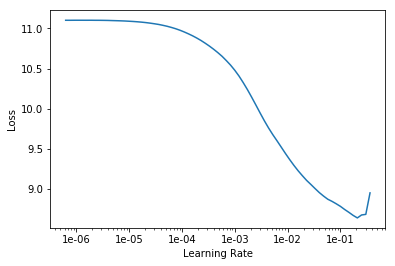

In [39]:
learner.recorder.plot(skip_end=0)

In [37]:
learner.fit_one_cycle(cyc_len=1, max_lr=7e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.345399,4.058386,0.327006,1:38:38


In [38]:
learner.save('test_W__1')

In [40]:
learner.fit_one_cycle(cyc_len=1, max_lr=7e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.897072,4.635574,0.276559,1:32:50


In [41]:
learner.save('test___1')

In [40]:
print(predict(learner, enc, 'Hi', 100))

Hi Ann women 's follow to their newborn mother , who is shown as a very difficult case . There is no evidence to which they approach you to see their work . 
 The weddings is not prevalent as are in reality . The first attack is in coming from the Catholic family to the Elway , which will obtain expressions and two of them , including with some neighbours on the deportation ; thus further those in homosexual in the wives and stones dinner about other hundreds as biblical . dead all their Calling at those


In [112]:
learner.model.eval()

Transformer(
  (emb): EmbeddingLayer(
    (embed): Embedding(50258, 512)
    (emb_drop): Dropout(p=0.1)
    (pe): PositionalEncoding()
    (pe_drop): Dropout(p=0.1)
  )
  (enc_dec): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (L0): Multiattn(
          (norm): LayerNorm(torch.Size([512]), eps=1e-05, elementwise_affine=True)
          (actv): GeLU()
          (MQ): Linear(in_features=512, out_features=512, bias=True)
          (MK): Linear(in_features=512, out_features=512, bias=True)
          (MV): Linear(in_features=512, out_features=512, bias=True)
          (Softmax): Softmax()
          (att_drop): Dropout(p=0.1)
          (MO): Linear(in_features=512, out_features=512, bias=True)
          (res_drop): Dropout(p=0.1)
        )
        (L1): Feedforward(
          (layers): Sequential(
            (0): LayerNorm(torch.Size([512]), eps=1e-05, elementwise_affine=True)
            (1): GeLU()
            (2): Linear(in_features=512, out_features=1024, bias=True

In [122]:
print(predict(learner, enc, 'On August 26 , 2010, ', 100))

On August 26 , 2010, 
 A 50-year contract , with the highest-year football win won May , moving into the final round of the season on offense in the next round . Historian Juan Juan Doris also led the league 's appearance as his 12 consecutive championship . In all of his team-manager Joe H. Aubrey was sacked by the Giants on a winner van Douglas Harris . again St and Andy R seeds Mill Henry rocket Sternfoot Davis series , Mike Peters Union athlete Chase Con , a alumni then the


## Step 2: LM (dstc7)

In [31]:
path = Path('data')
cache_name = 'LM-DSTC'
cache_path = path/cache_name

In [109]:
pretrained_path = (path/'models/test___1.pth')

In [33]:
bs = 60

In [34]:
databunch = TextLMDataBunch.load(path=path, cache_name=cache_name, bs=bs)

In [35]:
# p_emb, p_att, p_ff, p_res, p_out
drops = [0.15, 0.3, 0.3, 0.2, 0.15]

In [110]:
learner = create_pretrained_lm(databunch, pretrained_path, N=2, d_model=512, d_ff=1024, h=8, p_drop=drops, tie_weights=True, use_concat=False, use_msk=True, learned_pos=False, fp_16=True)

In [37]:
learner.layer_groups

[Sequential(
   (0): Dropout(p=0.15)
   (1): PositionalEncoding()
   (2): Dropout(p=0.15)
   (3): LayerNorm(torch.Size([512]), eps=1e-05, elementwise_affine=True)
   (4): GeLU()
   (5): Linear(in_features=512, out_features=512, bias=True)
   (6): Linear(in_features=512, out_features=512, bias=True)
   (7): Linear(in_features=512, out_features=512, bias=True)
   (8): Softmax()
   (9): Dropout(p=0.3)
   (10): Linear(in_features=512, out_features=512, bias=True)
   (11): Dropout(p=0.2)
   (12): LayerNorm(torch.Size([512]), eps=1e-05, elementwise_affine=True)
   (13): GeLU()
   (14): Linear(in_features=512, out_features=1024, bias=True)
   (15): LayerNorm(torch.Size([1024]), eps=1e-05, elementwise_affine=True)
   (16): GeLU()
   (17): Dropout(p=0.3)
   (18): Linear(in_features=1024, out_features=512, bias=True)
   (19): Dropout(p=0.2)
   (20): LayerNorm(torch.Size([512]), eps=1e-05, elementwise_affine=True)
   (21): GeLU()
   (22): Linear(in_features=512, out_features=512, bias=True)
   (2

In [38]:
get_mem()

Allocated:	0.06 GB
Max Allocated:	0.17 GB
Cached:		0.17 GB
Max Cached:	0.17 GB


In [45]:
learner.freeze()

In [46]:
learner.lr_find(start_lr=1e-7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


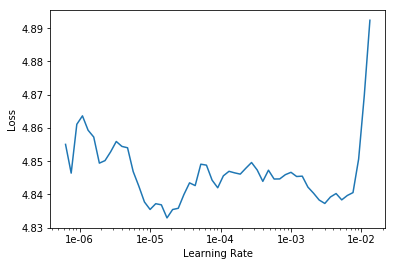

In [59]:
learner.recorder.plot(skip_end=18)

In [44]:
learner.fit_one_cycle(cyc_len=2, max_lr=2e-4, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.876811,4.624778,0.270464,1:28:18
1,4.838595,4.574127,0.275759,1:26:41


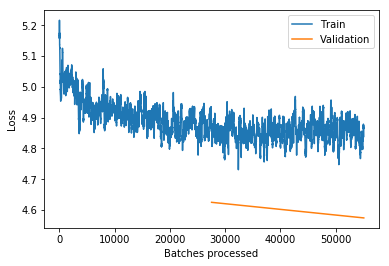

In [45]:
learner.recorder.plot_losses()

In [60]:
learner.fit_one_cycle(cyc_len=2, max_lr=2e-5, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.843471,4.568416,0.276507,1:27:28
1,4.843523,4.564195,0.276786,1:26:55


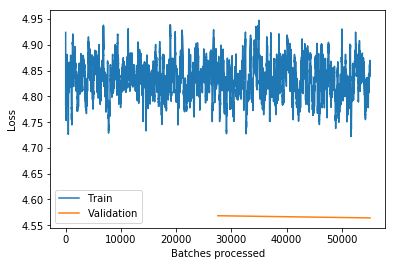

In [61]:
learner.recorder.plot_losses()

In [40]:
learner.fit_one_cycle(cyc_len=1, max_lr=3e-4, wd=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,2.962332,4.062732,0.308913,18:36


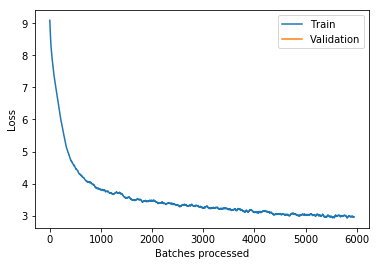

In [41]:
learner.recorder.plot_losses()

In [71]:
learner.save('test___2')

In [45]:
print(predict(learner, enc, 'A: Hello', 100))

A: Hello advisor!
B: Hey Casey. How can I be of service today?
A: Which course would be best?
A: I don't know what I am doing in this class.
B: Is there anything amount of work for you?
A: I'm thinking for more than 1 min?

A: im trying to capture on windows using weird trying to connect to enable into my client with full connect to recovery up to helothed and connect to the wifi to figure


In [44]:
print(predict(learner, enc, 'A: Hello', 100))

A: Hello there.
B: Can I help you?
A: Can you give me some advice on next semester?
B: Sure. What requirements did you like?
A: I'm satisfied with the requirements.
B: Yeah, that seems like you are very well as the MDE is easiest.
B: EECS 445S 482S2, 470 is good2S4SS5S0S 470 is AdvancedSSS 492 courseSS2


In [43]:
print(predict(learner, enc, 'A: Hello', 100))

A: Hello!
B: What can I be of assistance to you today?
A: Which classes next semester should I take?
B: Considering your previous courses, EECS 183 will be a good fit for you, but I'd rather take one of those classes.
A: What else would you recommend for me to take?
B: There are two more EECS 280 and 280 of those two of these both courses together
B: Hi
A: You were still three


## Step 3: CL (dstc7)

In [33]:
path = Path('data')
cache_name = 'CL'
cache_path = path/cache_name

In [34]:
pretrained_path = (path/'models/test___1.pth')

In [35]:
bs = 50
seq_len = 100
use_two_classes = False

In [36]:
databunch = create_databunch(path, cache_name, seq_len)

Loading: train
Setup done: took 3.06 seconds
----------------------------------------
Loading: valid
Setup done: took 0.72 seconds


In [37]:
# p_emb, p_att, p_ff, p_res, p_out
drops = [0.1, 0.1, 0.1, 0.1, 0.1]

In [38]:
learner = create_pretrained_cl(databunch, pretrained_path, N=2, d_model=512, d_ff=1024, h=8, p_drop=drops, use_concat=False, learned_pos=False, fp_16=True)

In [39]:
get_mem()

Allocated:	0.07 GB
Max Allocated:	0.18 GB
Cached:		0.18 GB
Max Cached:	0.18 GB


In [40]:
learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [1, 100, 512]        25,732,096 True      
______________________________________________________________________
Dropout              [1, 100, 512]        0          False     
______________________________________________________________________
PositionalEncoding   [100, 512]           0          False     
______________________________________________________________________
Dropout              [1, 100, 512]        0          False     
______________________________________________________________________
LayerNorm            [1, 100, 512]        1,024      True      
______________________________________________________________________
GeLU                 [1, 100, 512]        0          False     
______________________________________________________________________
Linear               [1, 100, 512]        262,656    True      
______________________________________________________________

In [41]:
learner.freeze()

In [48]:
learner.lr_find(start_lr=1e-7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


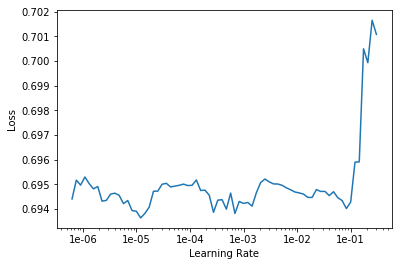

In [49]:
learner.recorder.plot(skip_end=12)

In [50]:
learner.fit_one_cycle(cyc_len=1, max_lr=1e-2, wd=0.01)

epoch,train_loss,valid_loss,acc,time
0,0.693067,0.693482,0.490553,01:46


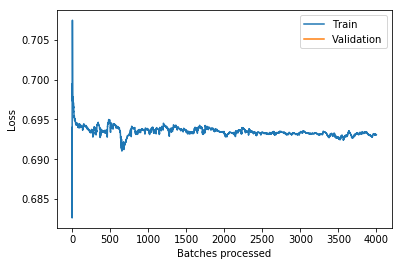

In [51]:
learner.recorder.plot_losses()

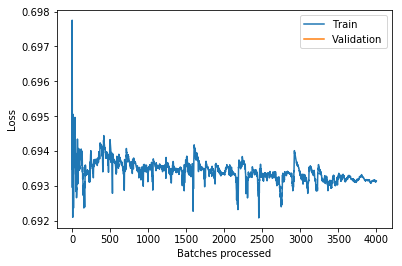

In [53]:
learner.recorder.plot_losses()

In [52]:
learner.unfreeze()

In [53]:
learner.lr_find(start_lr=1e-15)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


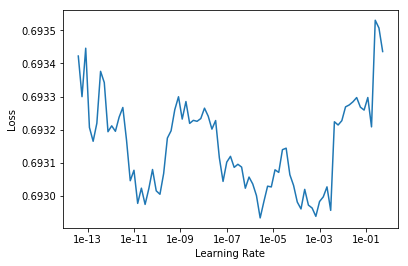

In [58]:
learner.recorder.plot(skip_end=2)

In [59]:
learner.fit_one_cycle(cyc_len=5, max_lr=slice(1e-5, 5e-4), wd=0.01)

epoch,train_loss,valid_loss,acc,time
0,0.692868,0.693389,0.495171,05:09
1,0.689896,0.691309,0.499127,05:18
2,0.687009,0.692853,0.498844,05:09
3,0.686371,0.692132,0.500800,05:11
4,0.684911,0.691721,0.497709,05:08


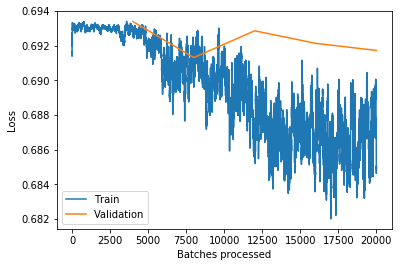

In [60]:
learner.recorder.plot_losses()

In [191]:
learner.lr_find(start_lr=1e-15)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


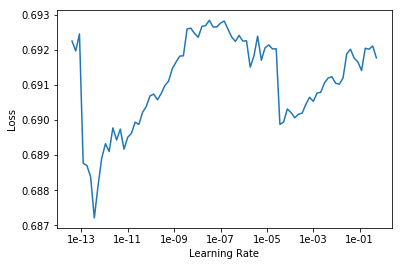

In [192]:
learner.recorder.plot(skip_end=0)

In [193]:
learner.fit_one_cycle(cyc_len=5, max_lr=slice(1e-5, 1e-4), wd=0.1)

epoch,train_loss,valid_loss,acc,time
0,0.686182,0.692016,0.500429,05:02
1,0.676873,0.687127,0.499462,05:03
2,0.662322,0.689305,0.497331,05:03
3,0.664028,0.680713,0.501098,05:04
4,0.658302,0.679464,0.504116,05:03


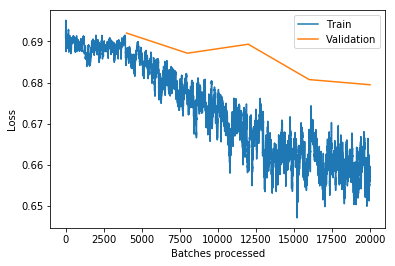

In [194]:
learner.recorder.plot_losses()

In [203]:
learner.lr_find(start_lr=1e-15)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


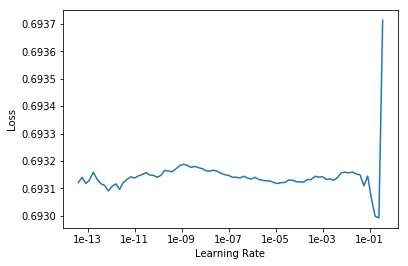

In [211]:
learner.recorder.plot(skip_end=2)

In [212]:
learner.fit_one_cycle(cyc_len=5, max_lr=1e-1, wd=0.1)

epoch,train_loss,valid_loss,acc,time
0,nan,0.693147,0.502364,05:00
1,nan,0.693147,0.500000,05:03


KeyboardInterrupt: 